In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import json
import tqdm
import requests
from tqdm.auto import tqdm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay, roc_auc_score, \
    confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, accuracy_score

tqdm.pandas()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set_style("darkgrid", {"grid.color": ".8", "grid.linestyle": ":"})
pd.set_option('mode.chained_assignment', None)

In [2]:
def metric_calculation(y_test: np.ndarray, y_predict: np.ndarray, y_pred_proba: np.ndarray) -> dict:
    print(f'Metrics:')
    
    acc = accuracy_score(y_test, y_predict)
    print(f"Accuracy: {acc}") 
    
    f1 = f1_score(y_test, y_predict)
    print(f"F1: {f1}") 
    
    roc = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC-AUC: {roc}") 
    
    rec = recall_score(y_test, y_predict)
    print(f"Recall: {rec}") 
    
    prc = precision_score(y_test, y_predict)
    print(f"Precision: {prc}") 
    
    cm = confusion_matrix(y_test, y_predict)
    tn, fp, fn, tp = cm.ravel()
    print(f"Confusion matrix: TN={tn} FP={fp} FN={fn} TP={tp}")
    
    return {"accuracy": acc, "f1 score": f1, "roc-auc score": roc, "recal score": rec, "precision score": prc, "conf_matrix": cm}

In [3]:
def plot_roc_auc_curve(y_true, y_pred_score):
    score = roc_auc_score(y_true, y_pred_score)
    print(f"ROC-AUC score: {score:.03f}")
    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_score)
    plt.figure(figsize=(9, 6))
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=plt.gca())
    plt.title(f"ROC-AUC кривая (Score: {score:.03f})")
    plt.grid()
    # plt.tight_layout()
    plt.show()
    return score

## Загрузим модель 

In [4]:
with open('model/model.dill', 'rb') as f:
    PIPELINE = dill.load(f)

# PIPELINE = pd.read_pickle('model/model.pickle')
PIPELINE

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('age',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='age')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('hypertension',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='hypertension')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('heart_disease',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='heart_disease')),
                                                                 ('...
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='HbA1c_level')),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('blood_glucose_level',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(key='blood_glucose_level')),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=10, n_estimators=150,
                                        n_jobs=-1, random_state=42))],
         verbose=True)

In [5]:
# наш сохраненный уровень
PIPELINE.my_thresholds_level

0.853320012068987

## Загрузим тестовые данные

In [6]:
X_test = pd.read_pickle('data/X_test.pickle')
y_test = pd.read_pickle('data/y_test.pickle')

## Проверим работу модели на тестовых данных

In [7]:
y_test_preds_proba = PIPELINE.predict_proba(X_test)[:, 1]
y_test_preds = y_test_preds_proba > PIPELINE.my_thresholds_level

ROC-AUC score: 0.977


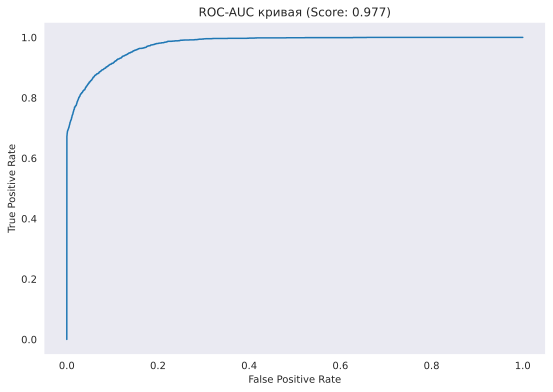

In [8]:
auc = plot_roc_auc_curve(y_test, y_test_preds_proba)

In [9]:
metrics = metric_calculation(y_test, y_test_preds, y_test_preds_proba)

Metrics:
Accuracy: 0.9722287047841307
F1: 0.8083735909822866
ROC-AUC: 0.9771253808865503
Recall: 0.6890196078431372
Precision: 0.9777406789092933
Confusion matrix: TN=27405 FP=40 FN=793 TP=1757


## Тест работы API

In [10]:
def predictions_from_api(row: pd.Series) -> float | None:
    assert isinstance(row, pd.Series), "Only Pandas Series allowed!"

    headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
    api_url = 'http://localhost:5000/predict'    
    
    try:
        json_data = row.to_json()
        response = requests.post(api_url, json=json_data, headers=headers)
        
        if response.status_code == 200:
            response_json = response.json()
            pred_dict = json.loads(response_json['predictions'])
            return pred_dict[0]['predict']
        else:
            print(response.status_code, response.text)
            return None
    
    except Exception as e:
        print(e)
    return None

### Проверка на одной строке из тестового набора

In [11]:
pos = 110
predictions_from_api(X_test.iloc[pos:pos+1].squeeze())

0.0

### Массовая проверка работы API

In [12]:
n = 100
x = X_test.iloc[:n].copy()
y = y_test.iloc[:n].copy()
df = pd.concat([x, y], axis=1)
df['predict'] = df.progress_apply(lambda row: predictions_from_api(row), axis=1)
df

  0%|          | 0/100 [00:00<?, ?it/s]

,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,predict
23391,19.0,0,0,3,19.97,3.5,160,0,0.0
3915,80.0,0,0,4,22.97,4.8,160,0,0.0
67303,45.0,0,0,0,37.85,4.8,85,0,0.0
54136,51.0,0,1,2,33.80,6.6,280,1,1.0
53487,79.0,0,1,1,31.58,6.1,280,1,1.0
...,...,...,...,...,...,...,...,...,...
42425,61.0,0,0,4,29.81,5.8,200,1,0.0
62103,34.0,0,0,0,32.58,5.7,155,1,0.0
58764,18.0,0,0,-1,22.01,4.5,200,0,0.0
55794,64.0,0,0,0,25.48,6.0,155,0,0.0


In [13]:
f1_score(df['diabetes'], df['predict'])

0.8